<a href="https://colab.research.google.com/github/gaborsarosi/ACRM_LGD/blob/main/ACRM_LGD_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

This code generates synthetic loss given default (LGD) data for a mortgage loan portfolio. It was used for a student seminar series on applied credit risk modelling at the University of Zurich in order for students to have data to use as basis for model development/evaluation.

Given that we know the data generating process, the optimal modelling choice for the synthetic data is maximum likelihood based on the data generating distribution. This is also included at the end.

# Create syntetic dataset

Model:

$lgd = 1 - \frac{RealEstateCollMV}{loanAmount} \cdot e^{-a - b X} -  \frac{OtherCollMV}{loanAmount}  \cdot y$

$X \in N(0,1)$

$y \in Bernoulli(p)$

$a,b,p$ depend on customer/collateral segments

In [2]:
cust_segments = ['private','corporate']
collateral_types = ['mortgage','retirement account','cash account']
re_types = ['appartment','single family house','office building']

In [3]:
recovery_rates = pd.DataFrame({'customer':cust_segments}).merge(pd.DataFrame({'collateral':collateral_types[1:]}),
                                                                how = 'cross')

In [4]:
recovery_rates = pd.concat([recovery_rates,
                            pd.DataFrame({'rr':[0.85,0.95,0,0.92]})],
                           axis = 1)

In [5]:
recovery_rates

,customer,collateral,rr
0,private,retirement account,0.85
1,private,cash account,0.95
2,corporate,retirement account,0.00
3,corporate,cash account,0.92


In [79]:
mort_haircuts = pd.DataFrame({'real estate type':re_types,'haircut':[0.85, 0.8, 0.7], 'sigma':[0.1,0.15,0.3]})

In [122]:
mort_haircuts

,real estate type,haircut,sigma
0,appartment,0.85,0.10
1,single family house,0.80,0.15
2,office building,0.70,0.30


In [9]:
av_ead = pd.DataFrame({'customer':cust_segments}).merge(pd.DataFrame({'real estate type':re_types}),
                                                                how = 'cross')

In [10]:
av_ead = pd.concat([av_ead,
                            pd.DataFrame({'av_ead':[0.7*1e6,1.2* 1e6,0,0,0,8.2 * 1e6],
                                          'sigma':[0.5,0.6,0,0,0,0.9]})],
                           axis = 1)

In [11]:
av_ead

,customer,real estate type,av_ead,sigma
0,private,appartment,700000.0,0.5
1,private,single family house,1200000.0,0.6
2,private,office building,0.0,0.0
3,corporate,appartment,0.0,0.0
4,corporate,single family house,0.0,0.0
5,corporate,office building,8200000.0,0.9


In [12]:
av_ead = av_ead.iloc[[0,1,5]]

In [13]:
av_ead

,customer,real estate type,av_ead,sigma
0,private,appartment,700000.0,0.5
1,private,single family house,1200000.0,0.6
5,corporate,office building,8200000.0,0.9


In [100]:
generate_entries = pd.DataFrame({'customer': ['private']*842 + ['corporate']*611,
                                 'real estate type': ['appartment']*623 + ['single family house'] * (842 - 623) + ['office building']*611,
                                 'rnd_loan': np.random.default_rng().normal(0,1.0, 842+611)})

In [101]:
generate_entries = generate_entries.merge(av_ead,
                                          on = ['customer', 'real estate type'],
                                          how = 'left')

In [102]:
generate_entries['rnd_loan_mult'] = (generate_entries['rnd_loan']*generate_entries['sigma']).map(np.exp)

In [103]:
generate_entries['loan amount'] = generate_entries['av_ead'] * generate_entries['rnd_loan_mult']

<Axes: >

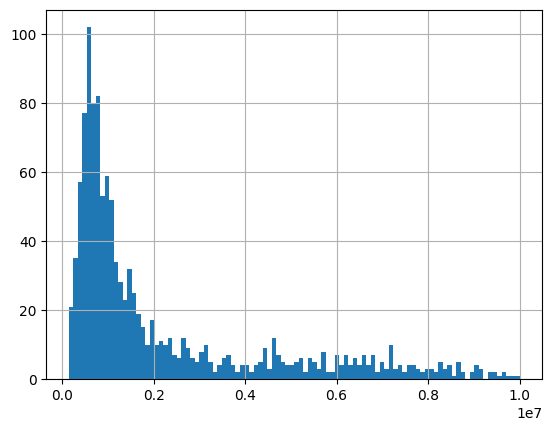

In [20]:
generate_entries.loc[generate_entries['loan amount']<1e7,'loan amount'].hist(bins = 100)

In [104]:
LTV = pd.DataFrame({'LTV': 0.82 + np.random.default_rng().normal(0,0.15, len(generate_entries))})
LTV_full = pd.DataFrame({'LTV_full': 0.8 + np.random.default_rng().normal(0,0.13, len(generate_entries))})

In [105]:
LTV.LTV.sort_values()

1359    0.328565
657     0.371035
385     0.371790
26      0.389621
1419    0.390506
          ...   
373     1.181870
406     1.191559
23      1.217152
1062    1.217522
1177    1.250512
Name: LTV, Length: 1453, dtype: float64

In [106]:
generate_entries = pd.concat([generate_entries,LTV, LTV_full],axis = 1)

In [107]:
generate_entries['mortgage collateral MV'] = 1/generate_entries['LTV'] * generate_entries['loan amount']

In [108]:
rand = pd.DataFrame({'mort_rand': np.random.default_rng().normal(0,1, len(generate_entries))})
generate_entries = generate_entries.merge(mort_haircuts,
                                          on = 'real estate type',
                                          how = 'left',
                                          suffixes = ('','_mort'))
generate_entries = pd.concat([generate_entries ,rand], axis = 1)

In [109]:
generate_entries['mortgage collateral LV'] = generate_entries['mortgage collateral MV'] * generate_entries['haircut'] *(( generate_entries['mort_rand']*generate_entries['sigma_mort']).map(np.exp))

<Axes: xlabel='mortgage collateral MV', ylabel='mortgage collateral LV'>

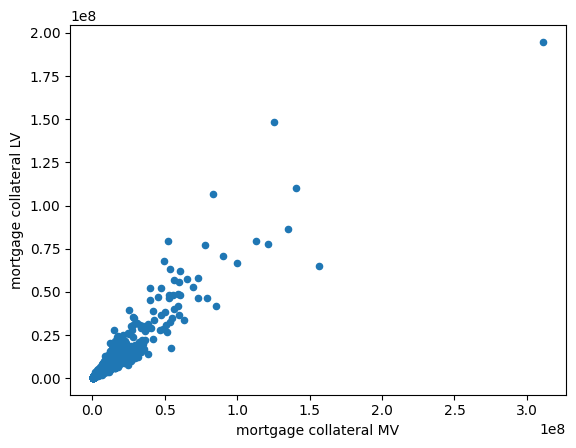

In [123]:
generate_entries.plot.scatter(x = 'mortgage collateral MV', y = 'mortgage collateral LV')

In [110]:
generate_entries['additional collateral MV'] = ( generate_entries['mortgage collateral MV']*(generate_entries['LTV']/generate_entries['LTV_full']- 1)).map(lambda x: max(x,0))

In [111]:
generate_entries['additional collateral type'] = 'retirement account'
generate_entries.loc[generate_entries['customer'] == 'corporate','additional collateral type'] = 'cash account'

In [112]:
generate_entries = generate_entries.merge(recovery_rates,
                                          left_on = ['customer', 'additional collateral type'],
                                          right_on = ['customer', 'collateral'],
                                          how = 'left')

In [113]:
generate_entries['recovery'] = generate_entries['rr'].map(lambda x: np.random.binomial(size=1, n=1, p= x)[0])

In [114]:
generate_entries.recovery.value_counts()

recovery
1    1260
0     193
Name: count, dtype: int64

In [115]:
generate_entries['lgd'] = ( generate_entries['loan amount'] - generate_entries['mortgage collateral LV'] - generate_entries['recovery']* generate_entries['additional collateral MV'])/generate_entries['loan amount']
generate_entries['lgd'] = generate_entries['lgd'].map(lambda x: min(max(x,0),1))

# Analyse and wrap for saving

<Axes: >

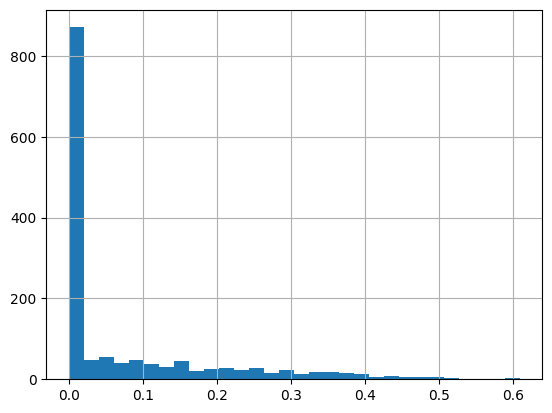

In [ ]:
generate_entries['lgd'].hist(bins = 30)

<Axes: xlabel='LTV_full', ylabel='lgd'>

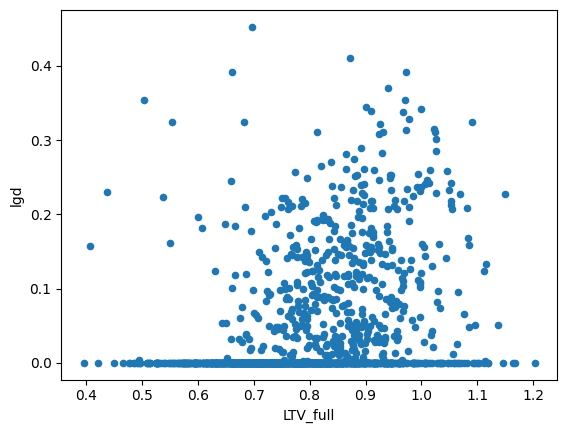

In [299]:
generate_entries.plot.scatter(x = 'LTV_full', y='lgd')

In [300]:
generate_entries['VTL'] = 1/generate_entries['LTV_full']

<Axes: xlabel='VTL', ylabel='lgd'>

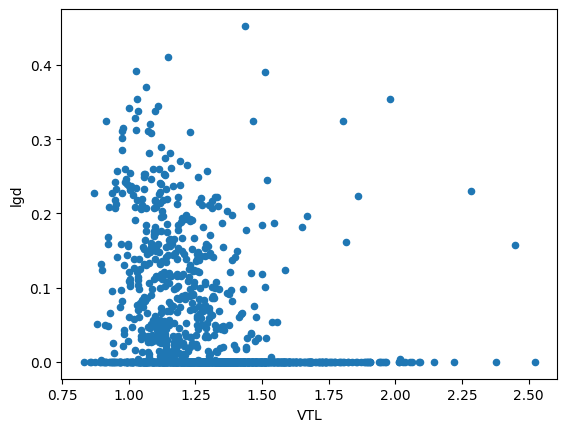

In [301]:
generate_entries.plot.scatter(x = 'VTL', y='lgd')

In [ ]:
generate_entries.loc[generate_entries['additional collateral MV'] == 0,'additional collateral type'] = 'none'

Save data.
We only keep original MVs as explanatory variables.

In [125]:
data = generate_entries[['customer',
                         'real estate type',
                         'loan amount',
                         'mortgage collateral MV',
                         'additional collateral MV',
                         'additional collateral type',
                         'lgd']].copy()

In [126]:
data

,customer,real estate type,loan amount,mortgage collateral MV,additional collateral MV,additional collateral type,lgd
0,private,appartment,2.206528e+06,2.276624e+06,1.359640e+06,retirement account,0.000000
1,private,appartment,1.324463e+06,1.879251e+06,0.000000e+00,retirement account,0.000000
2,private,appartment,4.266022e+05,5.481040e+05,8.308274e+04,retirement account,0.000000
3,private,appartment,5.719455e+05,5.475714e+05,1.942087e+05,retirement account,0.173541
4,private,appartment,1.455112e+06,2.121855e+06,0.000000e+00,retirement account,0.000000
...,...,...,...,...,...,...,...
1448,corporate,office building,1.464239e+07,1.878831e+07,0.000000e+00,cash account,0.313499
1449,corporate,office building,1.036540e+07,1.226266e+07,0.000000e+00,cash account,0.132817
1450,corporate,office building,2.167807e+06,2.447064e+06,7.839876e+05,cash account,0.000000
1451,corporate,office building,2.311446e+07,2.765770e+07,7.164854e+05,cash account,0.000000


In [ ]:
data.to_csv('lgd_data.csv')

# Max likelihood


Here we describe the optimal solution of the problem provided we know the data generating process.

First, we determine the distribution of the unfloored LGD, given an observation. It can be written as

$p(lgd)= \sum_{y\in(0,1)} p_y \int dX \frac{e^{-X^2/2}}{\sqrt{2\pi}} \delta(lgd - [1 - \frac{RealEstateCollMV}{loanAmount} \cdot e^{-a - b X} -  \frac{OtherCollMV}{loanAmount}  \cdot y])$

Here, $p_0 = 1-p$, $p_1=p$, while $\delta$ denotes the Dirac Delta function. Assuming positive collateral values, the $y=0$ branch has a solution when $lgd<1$ while the $y=1$ branch has a solution when $lgd<1-\frac{OtherCollMV}{loanAmount}$. The integrals have simple closed form solutions on these branches that are wrapped in the first part of the function `ll` below, with $chyp = \frac{RealEstateCollMV}{loanAmount}$ and $ckur = \frac{OtherCollMV}{loanAmount}$. The result is in the variable `l`.

Now our observed LGDs are floored at zero, that is we cannot observe negative LGDs (where most of the distribution would actually naturally lie). In order to score the likelihood of zero LGD observations, we therefore need to replace the above likelihood function with the entire probability mass at $lgd\leq 0$, given the observations. This is again easy to calculate in a closed form and the result is in variable `l0` in the function `ll` below.

In [36]:
from scipy.stats import norm

In [92]:
#Log-Likelihood function
def ll(lgd, chyp, ckur, a, b, p):
  if 1-lgd>0:
    a1 = np.exp(-(a - np.log(chyp/(1-lgd)))**2/(2*b**2))
  else:
    a1 = 0
  if 1-lgd-ckur>0:
    a2 = np.exp(-(a - np.log(chyp/(1-lgd-ckur)))**2/(2*b**2))
  else:
    a2 = 0

  l =  ( a1 * (1-p)/np.abs(b) /(1-lgd)  + a2 * p/np.abs(b) /(1-lgd-ckur) )/( np.sqrt(2 * np.pi))

  #Probability mass of lgd<=0 will be the likelihood for cases with lgd=0
  b1 = norm.cdf(-a/b + np.log(chyp)/b)
  if ckur<1:
    b2 = norm.cdf(-a/b + np.log(chyp/(1-ckur))/b)
  else:
    b2 = 1

  l0 = (1-p) * b1 + p * b2

  if lgd>0:
    return np.log(l + 1e-8)
  else:
    return np.log(l0 + 1e-8)



In [42]:
#Calculate log-likelihood of observation in dataframe
def add_ll(data, a, b, p):
  df = data.copy()
  df['loss'] = df.apply(lambda x : ll(x['lgd'],x['chyp'],x['ckur'],a,b,p),
                        axis = 1)
  return df

In [117]:
#Add required features
data['chyp'] = data['mortgage collateral MV']/data['loan amount']
data['ckur'] = data['additional collateral MV']/data['loan amount']

In [118]:
add_ll(data,0.2,0.3,0.9)

,customer,real estate type,loan amount,mortgage collateral MV,additional collateral MV,additional collateral type,lgd,chyp,ckur,loss
0,private,appartment,2.206528e+06,2.276624e+06,1.359640e+06,retirement account,0.000000,1.031768,0.616190,-0.078130
1,private,appartment,1.324463e+06,1.879251e+06,0.000000e+00,retirement account,0.000000,1.418878,0.000000,-0.369173
2,private,appartment,4.266022e+05,5.481040e+05,8.308274e+04,retirement account,0.000000,1.284813,0.194755,-0.237221
3,private,appartment,5.719455e+05,5.475714e+05,1.942087e+05,retirement account,0.173541,0.957384,0.339558,-0.155492
4,private,appartment,1.455112e+06,2.121855e+06,0.000000e+00,retirement account,0.000000,1.458208,0.000000,-0.324848
...,...,...,...,...,...,...,...,...,...,...
1448,corporate,office building,1.464239e+07,1.878831e+07,0.000000e+00,cash account,0.313499,1.283145,0.000000,-0.344469
1449,corporate,office building,1.036540e+07,1.226266e+07,0.000000e+00,cash account,0.132817,1.183038,0.000000,0.359592
1450,corporate,office building,2.167807e+06,2.447064e+06,7.839876e+05,cash account,0.000000,1.128820,0.361650,-0.172205
1451,corporate,office building,2.311446e+07,2.765770e+07,7.164854e+05,cash account,0.000000,1.196554,0.030997,-0.672655


In [46]:
import numpy as np
from scipy.optimize import minimize

In [47]:
#Loss function to minimize
def loss(x, data):
  return -add_ll(data,x[0],x[1],x[2])['loss'].sum()

In [67]:
#Set range for parameters
from scipy.optimize import Bounds
bounds = Bounds([1e-5,-1e-5,0.0], [np.inf,np.inf,1.0])

In [49]:
#Define buckets where we estimate parameters separately
buckets = data[['customer','real estate type','additional collateral type']].drop_duplicates()
buckets

,customer,real estate type,additional collateral type
0,private,appartment,retirement account
623,private,single family house,retirement account
842,corporate,office building,cash account


In [119]:
#Find optimal parameters
res = []
for i in range(len(buckets)):
  b = buckets.iloc[i]
  res += [minimize(lambda x: loss(x,data.loc[(data['customer'] == b['customer'])
                                              & (data['real estate type'] == b['real estate type'])
                                                & (data['additional collateral type'] == b['additional collateral type'])]),
                  [0.1,0.1,0.5],
                   bounds = bounds)]

In [120]:
#Package results
result = pd.DataFrame({'a':[r.x[0] for r in res],'b':[r.x[1] for r in res],'p':[r.x[2] for r in res]})
result['mort_haircut'] = result['a'].map(lambda x: np.exp(-x))
result['sigma'] = result['b']

In [121]:
pd.concat([buckets.reset_index(drop = True),result[['mort_haircut','sigma','p']]],axis = 1)

,customer,real estate type,additional collateral type,mort_haircut,sigma,p
0,private,appartment,retirement account,0.852015,0.100266,0.830999
1,private,single family house,retirement account,0.801526,0.133496,0.857463
2,corporate,office building,cash account,0.695789,0.318159,0.931789


Comparing with the ground truth below, we find excellent match despite the multimodality and the violent flooring!

In [99]:
mort_haircuts

,real estate type,haircut,sigma
0,appartment,0.85,0.10
1,single family house,0.80,0.15
2,office building,0.70,0.30


In [11]:
recovery_rates

,customer,collateral,rr
0,private,retirement account,0.85
1,private,cash account,0.95
2,corporate,retirement account,0.00
3,corporate,cash account,0.92
